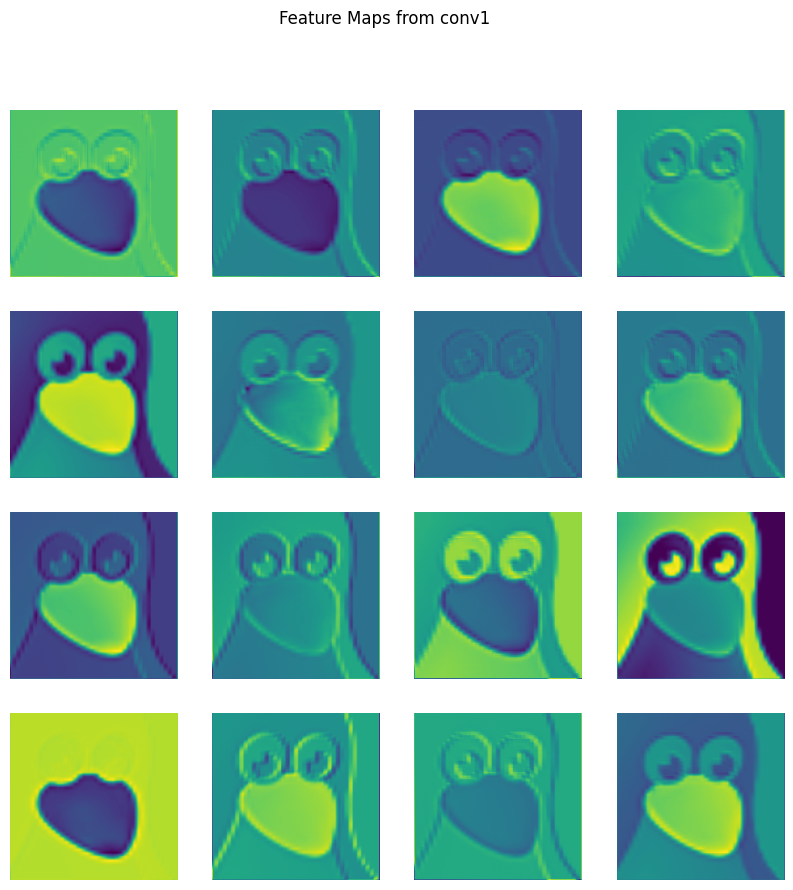

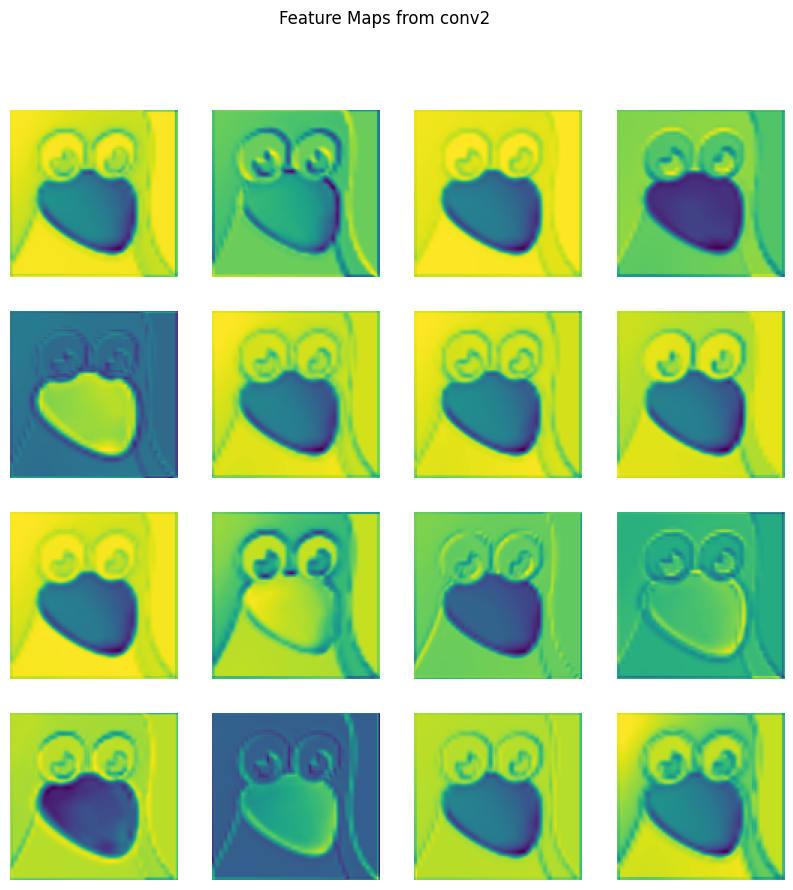

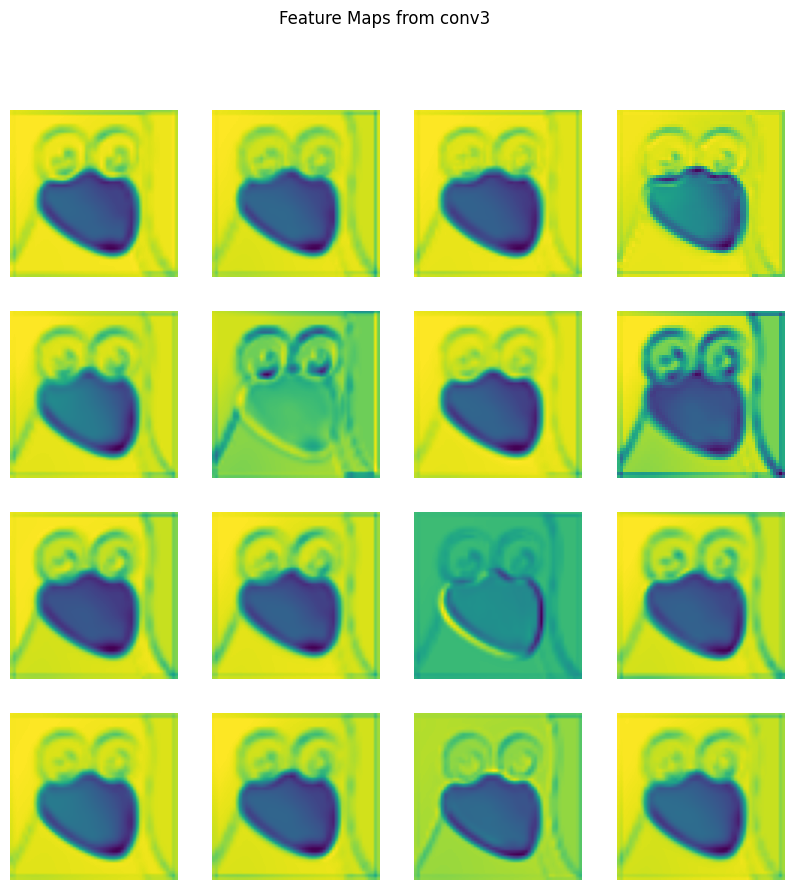

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Model Path & Image Path
dir_model = r"C:\Users\USER\Desktop\Projects\PASD_Deteksi_Penyakit_Tanaman\Model\output_training\best_model_cnn.pth"
image_path = r"C:\Users\USER\Pictures\Screenshots\Screenshot 2024-12-19 182438.png"

# Define SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load Model
model = SimpleCNN(num_classes=10).to('cpu')
model.load_state_dict(torch.load(dir_model, map_location=torch.device('cpu')))
model.eval()

# Initialize global feature variables
features = {}

# Define hook function
def hook_fn(layer_name):
    def hook(module, input, output):
        features[layer_name] = output.detach()
    return hook

# Register hooks on all convolutional layers
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        module.register_forward_hook(hook_fn(name))

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Load and preprocess the image
input_tensor = preprocess_image(image_path)

# Forward pass through the model
with torch.no_grad():
    model(input_tensor)

# Visualize feature maps for all registered layers
def visualize_feature_maps(features_dict):
    for layer, fmap in features_dict.items():
        n_channels = fmap.shape[1]
        fig, axs = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle(f"Feature Maps from {layer}", fontsize=16)
        axs = axs.flatten()
        for idx, ax in enumerate(axs):
            if idx >= n_channels:
                break
            ax.imshow(fmap[0, idx].cpu().numpy(), cmap="viridis")
            ax.axis("off")
        
        for j in range(idx + 1, len(axs)):
            axs[j].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


if features:
    visualize_feature_maps(features)
else:
    print("Feature extraction failed. Ensure hooks are attached correctly.")